In [1]:
import os
from sacrebleu.metrics import BLEU, CHRF
bleu = BLEU(tokenize="flores200")
chrf = CHRF(word_order=2)

In [2]:
from datasets import load_dataset
ds_dict = {
    "English" : load_dataset("facebook/flores", "eng_Latn"),
    "French" : load_dataset("facebook/flores", "fra_Latn"),
    "Swahili" : load_dataset("facebook/flores", "swh_Latn"),
    "Wolof" : load_dataset("facebook/flores", "wol_Latn"),
    "German" : load_dataset("facebook/flores", "deu_Latn"),
}

In [ ]:
from comet import load_from_checkpoint, download_model
model_path = download_model("Unbabel/wmt22-comet-da")
model = load_from_checkpoint(model_path)

In [5]:
import json

direction = "Eng_to_Swh"
path = f"./generations/llama-3-8b/SONAR/{direction}"

count = 0
tgt_length = 1012

for filename in os.listdir(path):
    try :
        predictions = []
        with open(os.path.join(path, filename), "r") as fin :
            for line in fin :
                predictions.append(json.loads(line)["translation"])
    except :
        print("ERROR except")
        continue
    if len(predictions) != tgt_length :
        print(f"ERROR, the number of predictions ({len(predictions)}) is not what we expected ({tgt_length})")
        continue
        
    filename = filename[:-len(".jsonl")]
    features = filename.split("_")
    source = features[0]
    target = features[2]

    print(f"source = {source}, target = {target}")

    sources = [example["sentence"] for example in ds_dict[source]["devtest"]][0:tgt_length] 
    targets = [example["sentence"] for example in ds_dict[target]["devtest"]][0:tgt_length]
    b = bleu.corpus_score(predictions, [targets]).score
    c = chrf.corpus_score(predictions, [targets]).score

    data = [
        {
            "src" : sources[i],
            "mt" : predictions[i],
            "ref" : targets[i]
        }
        for i in range(len(predictions))
    ]
        
    count += 1
    comet_score = None
    """
    model_output = model.predict(data)
    comet_score = model_output.system_score
    """
    
    print(f"{count}: {filename}\nBLEU = {b}\nchrF++ = {c}\nCOMET = {comet_score}\n")

source = English, target = Swahili
1: English_to_Swahili_10_shot_seed_122_template_11_SONAR_s2s
BLEU = 24.442873896600293
chrF++ = 48.79891522969836
COMET = None

source = English, target = Swahili
2: English_to_Swahili_2_shot_seed_122_template_11_SONAR_s2s
BLEU = 22.330723515751018
chrF++ = 46.906223311594495
COMET = None

source = English, target = Swahili
3: English_to_Swahili_1_shot_seed_122_template_11_SONAR_s2s
BLEU = 21.083749723284978
chrF++ = 45.42857268070285
COMET = None

source = English, target = Swahili
4: English_to_Swahili_32_shot_seed_122_template_11_SONAR_s2s
BLEU = 25.363553023770532
chrF++ = 49.70003603228228
COMET = None

source = English, target = Swahili
5: English_to_Swahili_5_shot_seed_122_template_11_SONAR_s2s
BLEU = 23.440404013866242
chrF++ = 47.8875292208703
COMET = None

source = English, target = Swahili
6: English_to_Swahili_20_shot_seed_122_template_11_SONAR_s2s
BLEU = 24.759039724485895
chrF++ = 49.170165842684014
COMET = None



In [5]:
# BLEU scores eng -> swh LLaMA 3 8B
# k-shot (1, 2, 5, 10, 20) Random, 3 seeds (13, 42, 122)
R = [
    [20.7455, 20.3195, 20.1332],
    [21.3160, 21.0040, 21.1240],
    [21.6187, 21.8474, 21.8234],
    [22.0316, 22.0048, 22.2246],
    [22.2042, 22.4031, 22.5191],
    [22.3038, 22.4573, 22.4590]
]
# COMET scores eng -> swh LLaMA 3 8B
S = [
    [0.7691, 0.7685, 0.7621],
    [0.7735, 0.7742, 0.7676],
    [0.7776, 0.7756, 0.7758],
    [0.7767, 0.7785, 0.7758],
    [0.7783, 0.7787, 0.7793],
    [0.7796, 0.7788, 0.7795]
]

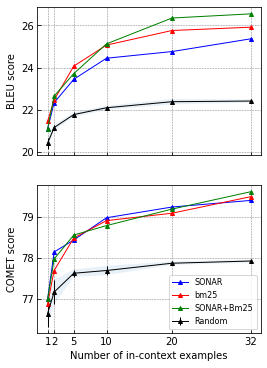

In [6]:
import matplotlib.pyplot as plt
import numpy as np
f, ax = plt.subplots(
    2, 1,
    sharex = True,
    figsize=(4, 6)
)
K = [1, 2, 5, 10, 20, 32]

random_mean = [np.mean(element) for element in R]
random_std = [np.std(element) for element in R]

ax[0].set_xticks(
    K
)
ax[0].errorbar(
    K,
    random_mean,
    random_std,
    label=f"Random", 
    linewidth=1.0,
    marker="^",
    markersize=4,
    color="black"
)

ax[0].fill_between(
    K, 
    [a - b for (a, b) in zip(random_mean, random_std)], 
    [a + b for (a, b) in zip(random_mean, random_std)],
    linewidth=0.0,
    alpha=0.1,
)


ax[0].plot(
    K,
    [21.0837, 22.3307, 23.4404, 24.4428, 24.7590, 25.3635],
    label=f"SONAR", 
    linewidth=1.0, 
    marker="^", 
    markersize=4,
    color='blue',
)

ax[0].plot(
    K,
    [21.4410, 22.4610, 24.0661, 25.0678, 25.7599, 25.9171],
    label=f"bm25", 
    linewidth=1.0, 
    marker="^", 
    markersize=4,
    color='red',
)

ax[0].plot(
    K,
    [21.0837, 22.6447, 23.7115, 25.1259, 26.3539, 26.5508],
    label=f"SONAR+Bm25", 
    linewidth=1.0, 
    marker="^", 
    markersize=4,
    color='green',
)

ax[0].set_ylabel("BLEU score")

random_mean = [100*np.mean(element) for element in S]
random_std = [100*np.std(element) for element in S]

ax[1].set_xticks(
    K
)
ax[1].errorbar(
    K,
    random_mean,
    random_std,
    label=f"Random", 
    linewidth=1.0,
    marker="^",
    markersize=4,
    color="black"
)

ax[1].fill_between(
    K, 
    [a - b for (a, b) in zip(random_mean, random_std)], 
    [a + b for (a, b) in zip(random_mean, random_std)],
    linewidth=0.0,
    alpha=0.1,
)

ax[1].plot(
    K,
    100*np.array([0.7700, 0.7815, 0.7844, 0.7898, 0.7924, 0.7940]),
    label=f"SONAR", 
    linewidth=1.0, 
    marker="^", 
    markersize=4,
    color='blue',
)

ax[1].plot(
    K,
    100*np.array([0.7689, 0.7770, 0.7849, 0.7891, 0.7909, 0.7949]),
    label=f"bm25", 
    linewidth=1.0, 
    marker="^", 
    markersize=4,
    color='red',
)

ax[1].plot(
    K,
    100*np.array([0.7700, 0.7798, 0.7856, 0.7879, 0.7919, 0.7961]),
    label=f"SONAR+Bm25", 
    linewidth=1.0, 
    marker="^", 
    markersize=4,
    color='green',
)
ax[1].set_ylabel("COMET score")

for i in [0, 1]:
    ax[i].grid(color="grey", linestyle="--", linewidth=0.5)
    ax[i].tick_params(direction = "in")

plt.xlabel("Number of in-context examples")
# plt.suptitle("LLaMA 3 8B: English to Swahili")
plt.legend(fontsize=8)
plt.show()